# 2D Image Segmentation of MRI scans

Steps:
1. Get dataset
1. Preprocess 2D images
    1. do a
    1. do b
1. Split dataset into train/val(/test) set
1. Setup a model
1. Set training and model parameters
1. Train model
1. Validate result


## Get dataset


In [1]:
!pip3 install natsort

In [2]:
import os
import random
import re
import numpy as np
from PIL import Image
from pathlib import Path

DATASET = "/Utrecht"
DATA_PATH = 'data_2d' + DATASET
SCAN_TYPE = 'T1'
FRAME_PATH = DATA_PATH
MASK_PATH = DATA_PATH

# Data path
# data_2d/<dataset>/<scan_id>/
# data_2d/<dataset>/<scan_id>/wmh_<slice_id>.tif
# data_2d/<dataset>/<scan_id>/orig/3DT1_<slice_id>.tif
# data_2d/<dataset>/<scan_id>/orig/T1_<slice_id>.tif
# data_2d/<dataset>/<scan_id>/orig/FLAIR_<slice_id>.tif
# data_2d/<dataset>/<scan_id>/pre/3DT1_<slice_id>.tif
# data_2d/<dataset>/<scan_id>/pre/T1_<slice_id>.tif
# data_2d/<dataset>/<scan_id>/pre/FLAIR_<slice_id>.tif


# Create folders to hold images and masks

folders = ['train_frames', 'train_masks', 'val_frames', 'val_masks', 'test_frames', 'test_masks']


# for folder in folders:
#       os.makedirs(DATA_PATH + folder)


# Get all frames and masks, sort them, shuffle them to generate data sets.

''' Recursively find all Images from a filepath matching the description 

    @return tuple (frames, masks) with list of all frames an accompanying mask
'''
def getAllImages(dataPath, scanType = "T1", preprocessed=True):
    if preprocessed:
        imageType = 'pre'
    else:
        imageType = 'orig'
    
    frameExpression = '**/{}/{}*.tiff'.format(imageType, scanType)
    maskExpression = '**/wmh_*.tiff' 
    a =  Path(DATA_PATH).glob(frameExpression)
    b =  Path(DATA_PATH).glob(maskExpression)

    while True:
        yield next(a), next(b)
    
    
    
# all_frames = os.listdir(FRAME_PATH)
# for frame in Path(DATA_PATH).glob('**/pre/{}*.tif'.format(SCAN_TYPE)):
#     print(frame)

# all_masks = os.listdir(MASK_PATH)

In [3]:
a = getAllImages(DATA_PATH)
all_frames = [str(x) for (x,_) in getAllImages(DATA_PATH) if 'checkpoint' not in str(x) ]

all_masks = [str(x) for (_,x) in getAllImages(DATA_PATH) if 'checkpoint' not in str(x)] 

from natsort import natsorted, ns
all_frames = natsorted(all_frames, alg=ns.IGNORECASE)
all_masks = natsorted(all_masks, alg=ns.IGNORECASE)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: generator 'getAllImages' raised StopIteration
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: generator 'getAllImages' raised StopIteration
  after removing the cwd from sys.path.


In [4]:
print(len(all_frames))
print(len(all_masks))
arr = [random.randint(0,len(all_frames)) for _ in range(10)]
for i in arr:
    print('Random entry in data:')
    print(f'frame {all_frames[i]}, mask  {all_masks[i]}')


   

600
600
Random entry in data:
frame data_2d/Utrecht/21/pre/T1_28.tiff, mask  data_2d/Utrecht/21/wmh_28.tiff
Random entry in data:
frame data_2d/Utrecht/19/pre/T1_36.tiff, mask  data_2d/Utrecht/19/wmh_36.tiff
Random entry in data:
frame data_2d/Utrecht/2/pre/T1_23.tiff, mask  data_2d/Utrecht/2/wmh_23.tiff
Random entry in data:
frame data_2d/Utrecht/49/pre/T1_23.tiff, mask  data_2d/Utrecht/49/wmh_23.tiff
Random entry in data:
frame data_2d/Utrecht/19/pre/T1_15.tiff, mask  data_2d/Utrecht/19/wmh_15.tiff
Random entry in data:
frame data_2d/Utrecht/21/pre/T1_18.tiff, mask  data_2d/Utrecht/21/wmh_18.tiff
Random entry in data:
frame data_2d/Utrecht/23/pre/T1_35.tiff, mask  data_2d/Utrecht/23/wmh_35.tiff
Random entry in data:
frame data_2d/Utrecht/23/pre/T1_27.tiff, mask  data_2d/Utrecht/23/wmh_27.tiff
Random entry in data:
frame data_2d/Utrecht/11/pre/T1_23.tiff, mask  data_2d/Utrecht/11/wmh_23.tiff
Random entry in data:
frame data_2d/Utrecht/19/pre/T1_28.tiff, mask  data_2d/Utrecht/19/wmh_28

In [5]:
# all_frames.sort(key=lambda var:[int(x) if x.isdigit() else x 
#                                 for x in re.findall(r'[^0-9]|[0-9]+', var)])
# all_masks.sort(key=lambda var:[int(x) if x.isdigit() else x 
#                                for x in re.findall(r'[^0-9]|[0-9]+', var)])
# for i in range(10):
#     print(all_frames[i])
#     print(all_masks[i])
#     print()

# Get all indices     
idxs = [x for x in range(len(all_frames))]


## Split dataset into train, val and testset

In [6]:
random.seed(230)
random.shuffle(idxs)

# Generate train, val, and test sets for frames

train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1


train_split = int(0.7*len(all_frames))
val_split = int(0.9 * len(all_frames))

train_idxs = idxs[:train_split]
val_idxs = idxs[train_split:val_split]
test_idxs = idxs[val_split:]

In [7]:
# Get corresponding frames
train_frames = [all_frames[idx] for idx in train_idxs]
val_frames = [all_frames[idx] for idx in val_idxs]
test_frames = [all_frames[idx] for idx in test_idxs]

# Get corresponding masks
train_masks = [all_masks[idx] for idx in train_idxs]
val_masks = [all_masks[idx] for idx in val_idxs]
test_masks = [all_masks[idx] for idx in test_idxs]


In [8]:
x= 100
print(idxs[x])
print(all_frames[idxs[x]])
print(train_frames[x])
print(all_masks[idxs[x]])
print(train_masks[x])

256
data_2d/Utrecht/21/pre/T1_25.tiff
data_2d/Utrecht/21/pre/T1_25.tiff
data_2d/Utrecht/21/wmh_25.tiff
data_2d/Utrecht/21/wmh_25.tiff


In [9]:
# #Add train, val, test frames and masks to relevant folders


# def add_frames(dir_name, image):
  
#     img = Image.open(FRAME_PATH+image)
#     img.save(DATA_PATH+'/{}'.format(dir_name)+'/'+image)
  
  

# def add_masks(dir_name, image):  
#     img = Image.open(MASK_PATH+image)
#     img.save(DATA_PATH+'/{}'.format(dir_name)+'/'+image)


  
  
# frame_folders = [(train_frames, 'train_frames'), (val_frames, 'val_frames'), 
#                  (test_frames, 'test_frames')]

# mask_folders = [(train_masks, 'train_masks'), (val_masks, 'val_masks'), 
#                 (test_masks, 'test_masks')]

# # Add frames

# for folder in frame_folders:
#     array = folder[0]
#     name = [folder[1]] * len(array)

#     list(map(add_frames, name, array))
         
    
# # Add masks

# for folder in mask_folders:
#     array = folder[0]
#     name = [folder[1]] * len(array)
    
#     list(map(add_masks, name, array))

In [10]:
import cv2
import matplotlib.pyplot as plt
def load_images_from_path_array(path_array):
    # Load all images (in memory for now)
    imgs = []
    for path in path_array:
        imgs.append(cv2.imread(path))
    return np.array(imgs)

train_x = load_images_from_path_array(train_frames).astype("float") / 255.0
train_y = load_images_from_path_array(train_masks).astype("float") / 255.0

val_x = load_images_from_path_array(val_frames).astype("float") / 255.0
val_y = load_images_from_path_array(val_masks).astype("float") / 255.0

test_x = load_images_from_path_array(test_frames).astype("float") / 255.0
test_y = load_images_from_path_array(test_masks).astype("float") / 255.0

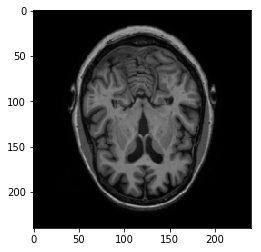

In [11]:
# Show one
plt.figure()
plt.imshow(train_x[0])
plt.show()

In [12]:
print(train_x.shape)
print(train_x[0,:,:,0].reshape(240,240,1).shape)
train_x = train_x[:,:,:,0].reshape(420,240,240,1)
train_y = train_y[:,:,:,0].reshape(420,240,240,1)
print(train_x.shape)

(420, 240, 240, 3)
(240, 240, 1)
(420, 240, 240, 1)


In [13]:
print(val_x.shape)

(120, 240, 240, 3)


In [14]:
val_x = val_x[:,:,:,0].reshape(120,240,240,1)
val_y = val_y[:,:,:,0].reshape(120,240,240,1)

## Data is here. 

- [train/val/test]_[frames|masks]

Let's go


In [15]:
from model_unet import *
model = unet(input_size=(240,240,1))#train_x[0].shape)

Using TensorFlow backend.
W0802 15:15:42.923691 140338572973888 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 240, 240, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 240, 240, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 240, 240, 64) 36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 120, 120, 64) 0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

/home/shared/model_unet.py:55: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`
  model = Model(input = inputs, output = conv10)


In [16]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 240, 240, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 240, 240, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 240, 240, 64) 36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 120, 120, 64) 0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

In [17]:
from keras import backend as K

def jaccard_distance_loss(y_true, y_pred, smooth=100):
    """
    Jaccard = (|X & Y|)/ (|X|+ |Y| - |X & Y|)
            = sum(|A*B|)/(sum(|A|)+sum(|B|)-sum(|A*B|))
    
    The jaccard distance loss is usefull for unbalanced datasets. This has been
    shifted so it converges on 0 and is smoothed to avoid exploding or disapearing
    gradient.
    
    Ref: https://en.wikipedia.org/wiki/Jaccard_index
    
    @url: https://gist.github.com/wassname/f1452b748efcbeb4cb9b1d059dce6f96
    @author: wassname
    """
    intersection = K.sum(K.abs(y_true * y_pred))
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred))
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth


In [18]:
model_checkpoint = ModelCheckpoint('unet_membrane.hdf5', monitor='loss',verbose=1, save_best_only=True)
# model.loss = jaccard_distance_loss
model.fit(
    train_x,
    train_y,
    batch_size=4,
    epochs=1, 
    validation_data=(val_x,val_y),
    callbacks=[model_checkpoint],
    verbose=1
)

Train on 420 samples, validate on 120 samples
Epoch 1/1
420/420 [==============================] - 87s 206ms/step - loss: 87.9000 - acc: 0.9945 - val_loss: 80.8894 - val_acc: 0.9949

Epoch 00001: loss improved from inf to 87.89996, saving model to unet_membrane.hdf5


In [33]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 240, 240, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 240, 240, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 240, 240, 64) 36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 120, 120, 64) 0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

In [ ]:
predictions = model.predict(test_x[:,:,:,1].reshape(test_x.shape[0],240,240,1), batch_size = 16)

In [46]:
for pred in predictions:
    print(pred.min() + ' ' + pred.max()) 
    

TypeError: ufunc 'add' did not contain a loop with signature matching types dtype('<U32') dtype('<U32') dtype('<U32')

In [42]:
predictions.min()

0.0

In [43]:
predictions.max()

0.0

(1, 240, 240, 1)


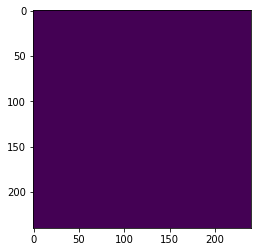

In [29]:
plt.figure()


plt.imshow(predictions[0,:,:,0] * 255)
plt.show()

In [19]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6609637718031168259
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 5384944624188776517
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 5854887467398042014
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3268149248
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2305701564947721928
physical_device_desc: "device: 0, name: GeForce GTX 1050 Ti with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [20]:
a= val_y.sum() / 256

In [21]:
b = a /(120*240*240)

In [22]:
1-b

0.9999833443480293

In [23]:
val_y[17].astype("float32").shape

(240, 240, 1)

In [24]:
a = jaccard_distance_loss(val_y[17].astype("float32"), val_y[18].astype("float32"))
y_true = val_y[17].astype("float32")
y_pred = val_y[18].astype("float32")
smooth =100

In [25]:
a.shape
tf.keras.backend.get_value(a)

91.405045

In [26]:
intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
jac = (intersection + smooth) / (sum_ - intersection + smooth)
    

In [27]:
tf.keras.backend.get_value(K.sum(K.abs(y_true * y_pred)))


4.4804

In [28]:
help (K.sum)

Help on function sum in module keras.backend.tensorflow_backend:

sum(x, axis=None, keepdims=False)
    Sum of the values in a tensor, alongside the specified axis.
    
    # Arguments
        x: A tensor or variable.
        axis: An integer or list of integers in [-rank(x), rank(x)),
            the axes to sum over. If `None` (default), sums over all
            dimensions.
        keepdims: A boolean, whether to keep the dimensions or not.
            If `keepdims` is `False`, the rank of the tensor is reduced
            by 1. If `keepdims` is `True`,
            the reduced dimension is retained with length 1.
    
    # Returns
        A tensor with sum of `x`.

